In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import gc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Activation, Bidirectional, LSTM, Attention
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1.keras.initializers import Constant
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt


In [2]:
train_df=pd.read_csv('../input/nlp-getting-started/train.csv')
test_df=pd.read_csv('../input/nlp-getting-started/test.csv')

In [3]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


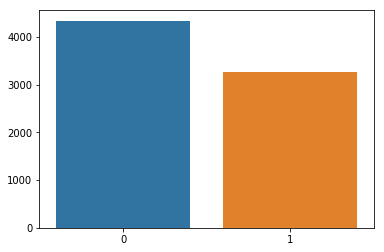

In [5]:
count=train_df['target'].value_counts()
sns.barplot(count.index, count.values )

## Preprocessing

In [6]:
def prepprocessing(text):
    text=text.replace(u'[#:}{[]/\']',' ')
    text=text.replace(u'?', '')
    text=text.replace(u'_', '')
    text=text.translate(str.maketrans('', '', string.punctuation))
    text=text.strip()
    text=text.lower()
    return text

In [7]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


In [8]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [9]:
def remove_stopwords(text):
    stopword=set(stopwords.words('english'))
    tokens=word_tokenize(text)
    filtered_text = [w for w in tokens if not w in stopword] 
    return filtered_text

In [10]:
target=train_df['target']

In [11]:
del train_df['target']

In [12]:
train_size=train_df.shape[0]

In [13]:
df=pd.concat([train_df,test_df])

In [14]:
df.reset_index(inplace=True)

In [15]:
df.drop(['index', 'id', 'keyword', 'location'], axis=1, inplace=True)

In [16]:
df['text']=df['text'].apply(lambda x : remove_html(x))
df['text']=df['text'].apply(lambda x : remove_URL(x))
df['text']=df['text'].apply(lambda x : prepprocessing(x))
# df['text']=df['text'].apply(lambda x :remove_stopwords(x))

In [17]:
t=Tokenizer()
t.fit_on_texts(df['text'])

In [ ]:
# df['text'] = df['text'].apply(lambda x : ' '.join(x))

In [18]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(df['text'], key=word_count)
MAX_LEN = len(word_tokenize(longest_sentence))

In [19]:
VOCAB_SIZE=len(t.word_index) + 1

In [20]:
seq=t.texts_to_sequences(df['text'])

In [21]:
padded_tweet=pad_sequences(seq, MAX_LEN, padding='post', truncating='post')

In [22]:
padded_tweet.shape

(10876, 31)

In [23]:
tweet_train=padded_tweet[:train_size]

In [24]:
tweet_test=padded_tweet[train_size:]

## Using Glove

In [25]:
embedding_dict={}

with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [26]:
embedding_matrix=np.zeros((VOCAB_SIZE,100))

for word,i in t.word_index.items():
    if i < VOCAB_SIZE:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec 

In [27]:
from tensorflow.python.keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [60]:
from tensorflow.keras.layers import Layer

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [92]:
class BahdanauAttention(Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
def create_model():
    model=Sequential()
    embedding=Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_LEN)
    X=Bidirectional(GRU(128, activation='tanh', return_sequences=True)))(embedding)
    X=(attention())(X)
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, activation='tanh', dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='RMSProp',metrics=['accuracy', f1])
    return model

In [97]:
def create_model():
    model=Sequential()
    embedding=Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_LEN)
    model.add(embedding)
    model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, activation='tanh', dropout=0.2)))
    print(model)
#     model.add(Attention())
    model.add(Dense(1, activation='sigmoid', trainable=True))
    model.compile(loss='binary_crossentropy',optimizer='RMSProp',metrics=['accuracy', f1])
    return model

In [98]:
X_train, X_test, y_train, y_test=train_test_split(tweet_train, target, test_size=0.20)

In [99]:
model=create_model()
model.summary()

ValueError: Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key].

In [ ]:
BATCH_SIZE=32
EPOCHS=50

In [58]:
history=model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_test, y_test))

Train on 6090 samples, validate on 1523 samples
Epoch 1/50
6090/6090 [==============================] - 11s 2ms/sample - loss: 0.4850 - accuracy: 0.7759 - f1: 0.7056 - val_loss: 0.4576 - val_accuracy: 0.8043 - val_f1: 0.7260
Epoch 2/50
6090/6090 [==============================] - 5s 761us/sample - loss: 0.4091 - accuracy: 0.8228 - f1: 0.7705 - val_loss: 0.4380 - val_accuracy: 0.8122 - val_f1: 0.7398
Epoch 3/50
6090/6090 [==============================] - 5s 749us/sample - loss: 0.3631 - accuracy: 0.8479 - f1: 0.8024 - val_loss: 0.4467 - val_accuracy: 0.8135 - val_f1: 0.7483
Epoch 4/50
6090/6090 [==============================] - 5s 801us/sample - loss: 0.3251 - accuracy: 0.8683 - f1: 0.8326 - val_loss: 0.4930 - val_accuracy: 0.8109 - val_f1: 0.7592
Epoch 5/50
6090/6090 [==============================] - 5s 885us/sample - loss: 0.2953 - accuracy: 0.8795 - f1: 0.8475 - val_loss: 0.4867 - val_accuracy: 0.8050 - val_f1: 0.7469
Epoch 6/50
6090/6090 [==============================] - 5s 796u

KeyboardInterrupt: 

In [ ]:
print(history.history.keys())

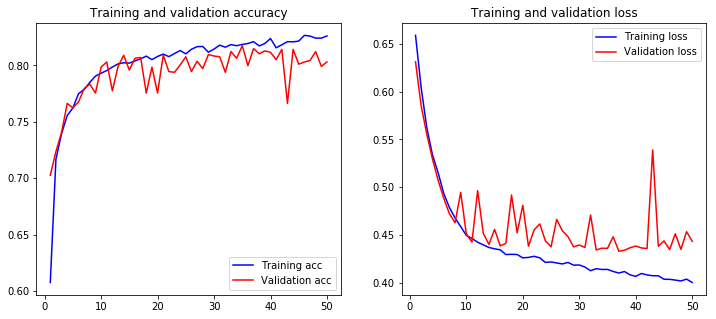

In [39]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

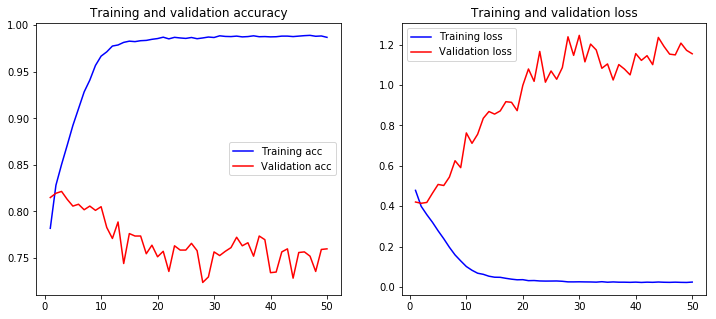

In [53]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
results=model.predict(tweet_test, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
list1=[]
for i in results: 
    if i>0.5:
        list1.append(1)
    else:
        list1.append(0)
        

In [ ]:
sub=pd.DataFrame(test_df['id'])

In [ ]:
sub['target']=list1

In [ ]:
sub.to_csv('prediction2.csv', index=False, sep=',')